<h1 style="text-align: center;">MCQ Creation Using OpenAI,Langchain,Huggingface and Pinecone </h1>

## Table of Contents
* #### Install Libraries
* #### Output in markdown format
* #### Entire function to generate MCQ
* #### Calling the function by passing a question as its argument
* #### Cleaning The output


# Flowchart to generate MCQ

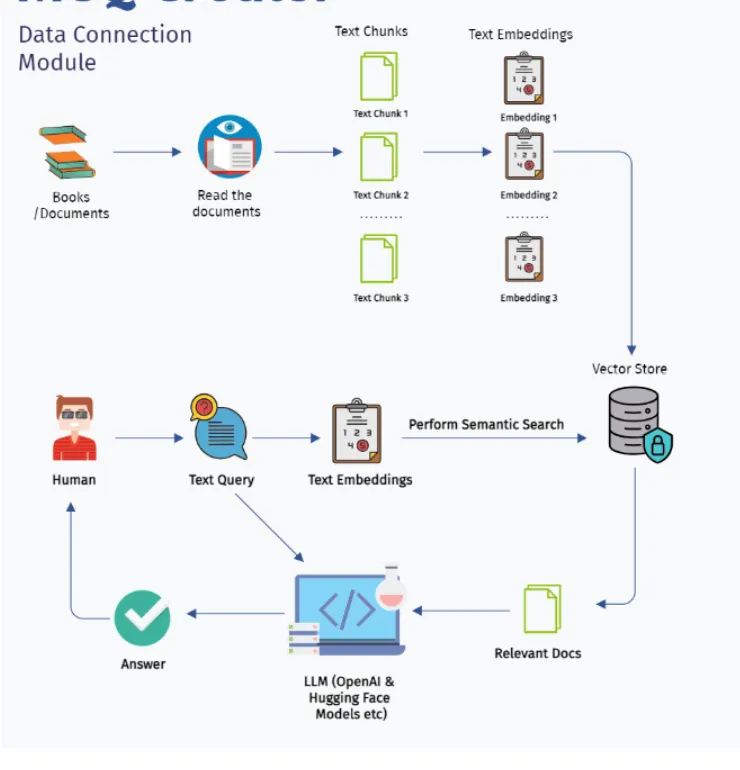

# Install Libraries

In [1]:
# !pip install openai
# !pip install unstructured
# !pip install tiktoken
# !pip install pinecone-client
# !pip install pypdf
#!pip install langchain
#!pip install sentence-transformers

# Output in json format

In [2]:
markdown_text=[]

# Entire function to generate MCQ

In [3]:
def get_mca_questions(k): 
    
    # Importing libraries and dependencies
    import openai
    import pinecone
    from langchain.document_loaders import PyPDFDirectoryLoader
    from langchain.text_splitter import RecursiveCharacterTextSplitter
    from langchain.embeddings.openai import OpenAIEmbeddings
    from langchain.vectorstores import Pinecone
    from langchain.llms import OpenAI
    from langchain.embeddings.sentence_transformer import SentenceTransformerEmbeddings
    
    # Import Dependencies
    # The code sets environment variables for accessing OpenAI API 
    # and Hugging Face Hub API using respective API keys
    import os
    os.environ["OPENAI_API_KEY"] = <your key>
    os.environ["HUGGINGFACEHUB_API_TOKEN"] = <your key>
    
    # Load Documents
    # Loads PDF files available in a directory with pypdf
    # Function to read documents
    def load_docs(directory):
      loader = PyPDFDirectoryLoader(directory)
      documents = loader.load()
      return documents

    # Passing the directory to the 'load_docs' function
    directory = 'nlp_docs/'
    documents = load_docs(directory)
    len(documents)
    
    # Transform Documents
    # Split document Into Smaller Chunks
    # This function will split the documents into chunks
    def split_docs(documents, chunk_size=1000, chunk_overlap=20):
      text_splitter = RecursiveCharacterTextSplitter(chunk_size=chunk_size, chunk_overlap=chunk_overlap)
      docs = text_splitter.split_documents(documents)
      return docs

    docs = split_docs(documents)
    # print(len(docs))
    
    # Generate Text Embeddings
    # Hugging Face LLM for creating Embeddings for documents/Text
    embeddings = SentenceTransformerEmbeddings(model_name="all-MiniLM-L6-v2")
    
    # Let's test our Embeddings model for a sample text
    query_result = embeddings.embed_query("Hello Buddy")
    # len(query_result)

    # Vector store - PINECONE
    # Pinecone allows for data to be uploaded into a vector database and true semantic 
    # search can be performed.
    # Not only is conversational data highly unstructured, but it can also be complex. 
    # Vector search and vector databases allows for similarity searches.
    # We will initialize Pinecone and create a Pinecone index by passing our documents,
    # embeddings model and mentioning the specific INDEX which has to be used
    # Vector databases are designed to handle the unique structure of vector embeddings, 
    # which are dense vectors of numbers that represent text. They are used in machine learning
    # to capture the meaning of words and map their semantic meaning.
    # These databases index vectors for easy search and retrieval by comparing values and 
    # finding those that are most similar to one another, making them ideal for natural language
    # processing and AI-driven applications.

    pinecone.init(
        api_key="d2d535cb-4552-4a9c-8128-b927a0697c39",
        environment="gcp-starter"
    )

    index_name = "mcq-assess"

    index = Pinecone.from_documents(docs, embeddings, index_name=index_name)
    
    # Retrieve Answers
    # This function will help us in fetching the top relevent documents from our 
    # vector store - Pinecone
    def get_similiar_docs(query, k=2):
        similar_docs = index.similarity_search(query, k=k)
        return similar_docs
    
    # 'load_qa_chain' Loads a chain that you can use to do QA over a set of documents.
    #  And we will be using Huggingface for the reasoning purpose
    from langchain.chains.question_answering import load_qa_chain
    from langchain import HuggingFaceHub
    
    # BigScience Large Open-science Open-access Multilingual Language Model (BLOOM) 
    # is a transformer-based large language model.
    # It was created by over 1000 AI researchers to provide a free large language model 
    # for everyone who wants to try. Trained on around 366 billion tokens over March through July 2022,
    # it is considered an alternative to OpenAI's GPT-3 with its 176 billion parameters.
    llm=HuggingFaceHub(repo_id="bigscience/bloom", model_kwargs={"temperature":1e-10})
    
    # Different Types Of Chain_Type:
    # "map_reduce": It divides the texts into batches, processes each batch separately with 
    # the question, and combines the answers to provide the final answer.
    # "refine": It divides the texts into batches and refines the answer by sequentially processing 
    # each batch with the previous answer.
    # "map-rerank": It divides the texts into batches, evaluates the quality of each answer from LLM,
    # and selects the highest-scoring answers from the batches to generate the final answer. These 
    # alternatives help handle token limitations and improve the effectiveness of the 
    # question-answering process.
    chain = load_qa_chain(llm, chain_type="stuff")
    
    #This function will help us get the answer to the question that we raise
    def get_answer(query):
      relevant_docs = get_similiar_docs(query)
      print(relevant_docs)
      response = chain.run(input_documents=relevant_docs, question=query)
      return response

    our_query = k
    answer = get_answer(our_query)
    # print(answer)

    

    from langchain.chat_models import ChatOpenAI
    from langchain.schema import HumanMessage
    from langchain.prompts import PromptTemplate, ChatPromptTemplate, HumanMessagePromptTemplate
    from langchain.output_parsers import StructuredOutputParser, ResponseSchema

    response_schemas = [
        ResponseSchema(name="question", description="Question generated from provided input text data."),
        ResponseSchema(name="choices", description="Available options for a multiple-choice question in comma separated."),
        ResponseSchema(name="Correct Options", description="Two correct options for the asked question in ampersand separated.")
    ]

    output_parser = StructuredOutputParser.from_response_schemas(response_schemas)

    # This helps us fetch the instructions the langchain creates to fetch the response in 
    # desired format
    format_instructions = output_parser.get_format_instructions()

    # create ChatGPT object
    chat_model = ChatOpenAI()
    prompt = ChatPromptTemplate(
        messages=[
            HumanMessagePromptTemplate.from_template("""When a text input is given by the user, please generate multiple choice questions 
            from it along with the correct options. 
            \n{format_instructions}\n{user_prompt}""")  
        ],
        input_variables=["user_prompt"],
        partial_variables={"format_instructions": format_instructions}
    )

    final_query = prompt.format_prompt(user_prompt = answer)
#     final_query.to_messages()

    final_query_output = chat_model(final_query.to_messages())
    markdown_text.append(final_query_output.content)
    print(final_query_output.content)
    


    

# Calling the function by passing a question as its argument

In [4]:
lst=['What was one of the strategies employed by Tipu Sultan during his leadership?"',
    "What did the British realise about the countryside in Europe?",
    "what were the two main systems of indigo cultivation? ","which kings ruled Mysore?"]
for q in lst:
    get_mca_questions(q)

C:\Users\DELL\anaconda3\lib\site-packages\pinecone\index.py:4: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm
C:\Users\DELL\anaconda3\lib\site-packages\huggingface_hub\utils\_deprecation.py:127: FutureWarning: '__init__' (from 'huggingface_hub.inference_api') is deprecated and will be removed from version '0.19.0'. `InferenceApi` client is deprecated in favor of the more feature-complete `InferenceClient`. Check out this guide to learn how to convert your script to use it: https://huggingface.co/docs/huggingface_hub/guides/inference#legacy-inferenceapi-client.
  warnings.warn(warning_message, FutureWarning)


[Document(page_content='through trade, buying goods cheap and selling them at higher prices chap 1 -4.indd 10 4/22/2022 \n2:49:26 PM Rationalised 2023 -24 FROM TRADE TO TERRITORY 11 goods. Trade was carried on with \narms and trading posts were protected through fortifica tion. This effort to fortify settlements and \ncarry on profitable trade also led to intense conflict with local rulers. The company therefore found it \ndifficult to separate trade from politics. Let us see how this happened  \nTipu Sultan – The “Tiger of Mysore” The Company resorted to direct military confrontation when it \nsaw a threat to its political or economic interests. This can be illustrated with the case of the \nsouthern Indian state of Mysore. Mysore had grown in  strength under the leadership of powerful \nrulers like Haidar Ali (ruled from 1761 to 1782) and his famous son Tipu Sultan (ruled from 1782 to \n1799). Mysore controlled the profitable trade of the Malabar coast where the Company purchased', m

C:\Users\DELL\anaconda3\lib\site-packages\huggingface_hub\utils\_deprecation.py:127: FutureWarning: '__init__' (from 'huggingface_hub.inference_api') is deprecated and will be removed from version '0.19.0'. `InferenceApi` client is deprecated in favor of the more feature-complete `InferenceClient`. Check out this guide to learn how to convert your script to use it: https://huggingface.co/docs/huggingface_hub/guides/inference#legacy-inferenceapi-client.
  warnings.warn(warning_message, FutureWarning)


[Document(page_content='Crops for Europe The British also realised that the countryside could not only yield revenue, it could \nalso grow the crops that Europe required. By the late eighteenth century, the Company was trying its \nbest to expand the cultivation of opium and indigo. In the century and a half that followed, the \nBritish persuaded or forced cultivators in various parts of India to produce other crops: jute in \nBengal, tea in Assam, sugarcane in the United Provinces (now Uttar Pradesh), wheat in Punjab, \ncotton in Maharashtra and Punjab, rice in Madras. How was this done ? The British used a variety of \nmethods to expand the cultivation of crops that they needed. Let us take a closer look at the story of \none such crop, one such method of production . \nHow was indigo cultivated? There were two main systems of indigo cultivation – nij and ryoti. Within \nthe system of nij cultivation, the planter produced indigo in lands that he directly  controlled. He', metadata={'

C:\Users\DELL\anaconda3\lib\site-packages\huggingface_hub\utils\_deprecation.py:127: FutureWarning: '__init__' (from 'huggingface_hub.inference_api') is deprecated and will be removed from version '0.19.0'. `InferenceApi` client is deprecated in favor of the more feature-complete `InferenceClient`. Check out this guide to learn how to convert your script to use it: https://huggingface.co/docs/huggingface_hub/guides/inference#legacy-inferenceapi-client.
  warnings.warn(warning_message, FutureWarning)


[Document(page_content='Crops for Europe The British also realised that the countryside could not only yield revenue, it could \nalso grow the crops that Europe required. By the late eighteenth century, the Company was trying its \nbest to expand the cultivation of opium and indigo. In the century and a half that followed, the \nBritish persuaded or forced cultivators in various parts of India to produce other crops: jute in \nBengal, tea in Assam, sugarcane in the United Provinces (now Uttar Pradesh), wheat in Punjab, \ncotton in Maharashtra and Punjab, rice in Madras. How was this done ? The British used a variety of \nmethods to expand the cultivation of crops that they needed. Let us take a closer look at the story of \none such crop, one such method of production . \nHow was indigo cultivated? There were two main systems of indigo cultivation – nij and ryoti. Within \nthe system of nij cultivation, the planter produced indigo in lands that he directly  controlled. He', metadata={'

C:\Users\DELL\anaconda3\lib\site-packages\huggingface_hub\utils\_deprecation.py:127: FutureWarning: '__init__' (from 'huggingface_hub.inference_api') is deprecated and will be removed from version '0.19.0'. `InferenceApi` client is deprecated in favor of the more feature-complete `InferenceClient`. Check out this guide to learn how to convert your script to use it: https://huggingface.co/docs/huggingface_hub/guides/inference#legacy-inferenceapi-client.
  warnings.warn(warning_message, FutureWarning)


[Document(page_content='through trade, buying goods cheap and selling them at higher prices chap 1 -4.indd 10 4/22/2022 \n2:49:26 PM Rationalised 2023 -24 FROM TRADE TO TERRITORY 11 goods. Trade was carried on with \narms and trading posts were protected through fortifica tion. This effort to fortify settlements and \ncarry on profitable trade also led to intense conflict with local rulers. The company therefore found it \ndifficult to separate trade from politics. Let us see how this happened  \nTipu Sultan – The “Tiger of Mysore” The Company resorted to direct military confrontation when it \nsaw a threat to its political or economic interests. This can be illustrated with the case of the \nsouthern Indian state of Mysore. Mysore had grown in  strength under the leadership of powerful \nrulers like Haidar Ali (ruled from 1761 to 1782) and his famous son Tipu Sultan (ruled from 1782 to \n1799). Mysore controlled the profitable trade of the Malabar coast where the Company purchased', m

**After  getting the raw results it is stored in the variable called markdown_text as a list**

# Cleaning The output

In [5]:
# Let's view the contents of the markdown_text
markdown_text

['known for his bravery and military tactics. He fought against the British East India Company in several battles.\n\n```json\n{\n\t"question": "What was Tipu Sultan known for?",\n\t"choices": "a) His strength, b) His strategic abilities, c) His bravery, d) His military tactics",\n\t"Correct Options": "b&d"\n}\n```',
 'was in high demand for. This led to the establishment of plantations in various colonies, including the Americas and the Caribbean. The British relied heavily on the labor of enslaved Africans to work on these plantations, which were primarily focused on producing cash crops such as sugar, tobacco, and cotton.\n\n```json\n{\n\t"question": "What led to the establishment of plantations in various colonies?",\n\t"choices": "a) High demand for crops, b) Revenue from the countryside, c) Availability of labor, d) All of the above",\n\t"Correct Options": "a&c"\n}\n```',
 'ryoti.\n\n```json\n{\n\t"question": "The two main systems of indigo cultivation were nij and _____?",\n\t"c

In [6]:
# Let's extract JSON data from Markdown text that we have
json_string=[]
import re
import json
for f in markdown_text:
    json_ = re.search(r'{(.*?)}',f, re.DOTALL).group(1)
    json_string.append(json_)

In [7]:
(json_string)

['\n\t"question": "What was Tipu Sultan known for?",\n\t"choices": "a) His strength, b) His strategic abilities, c) His bravery, d) His military tactics",\n\t"Correct Options": "b&d"\n',
 '\n\t"question": "What led to the establishment of plantations in various colonies?",\n\t"choices": "a) High demand for crops, b) Revenue from the countryside, c) Availability of labor, d) All of the above",\n\t"Correct Options": "a&c"\n',
 '\n\t"question": "The two main systems of indigo cultivation were nij and _____?",\n\t"choices": "a) ryoti, b) zamindari, c) mahalwari, d) ryotwari",\n\t"Correct Options": "a&d"\n',
 '\n\t"question": "Who were Haidar Ali and Tipu Sultan?",\n\t"choices": "a) Freedom fighters, b) Scientists, c) Politicians, d) Artists",\n\t"Correct Options": "a&c"\n']

# Some more cleaning to get the best results

In [8]:
ques=[]
choice=[]
answer=[]

In [9]:
for z in range(len(json_string)):
    u=[i for i in json_string[z].split(',')]
    t=[]
    t1=[]
    for j in u:
        for j1 in j.split(':'):
            if j1=='\n\t"question"' or j1=='\n    "question"':
                t.append(f'Q{1+z}')
                t.append(':')
                #print(j.split())
                e=j.split()
                t.append(' '.join(e[1:])+'\n')
            if j1=='\n\t"Correct Options"':
                t1.append('Correct Options')
                t1.append(':')
                #print(j.split())
                e=j.split()
                e1=[]
                for n in e[-1]:
                    e1.append(n)
                t1.append(f"'({e1[1].lower()})'")
                t1.append('&')
                t1.append(f"'({e1[-2].lower()})'")
    ques.append(t)
    answer.append(t1)
    # print(''.join(t))
    # print(''.join(t1))

    u1=[i for i in json_string[z].split()]
    t21=[]
    t2=[]
    for v in u1:
        if v=='"a)' or v=='"A)':
            x=u1.index(v)
            try:
                x1=u1.index('b)')
            except ValueError:
                x1=u1.index('B)')
            t2.append(' a.')
            t2.append(' '.join((u1[x+1:x1])))
            t21.append(' '.join(t2).replace(',','')+'\n')
    #         t21.append('\n')
            t2.clear()
        elif v=='b)' or v=='B)':
            x=u1.index(v)
            try:
                x1=u1.index('c)')
            except ValueError:
                x1=u1.index('C)')
            t2.append('b.')
            #t2.append(' '.join((u1[x+1:x1][:-1])))
            t2.append(' '.join((u1[x+1:x1])))
            t21.append(' '.join(t2).replace(',','')+'\n')
    #         t21.append('\n')
            t2.clear()
        elif v=='c)' or v=='C)':
            x=u1.index(v)
            try:
                x1=u1.index('d)')
            except ValueError:
                x1=u1.index('D)')
            t2.append('c.')
            t2.append(' '.join((u1[x+1:x1])))
            t21.append(' '.join(t2).replace(',','')+'\n')
    #         t21.append('\n')
            t2.clear()
        elif v=='d)' or v=='D)':
            x=u1.index(v)
    #         x1=u1.index('d)')
            t2.append('d.')
            t2.append(' '.join((u1[x+1:-3])))
            t21.append(' '.join(t2).replace('",',''))
    #         t21.append('\n')
            t2.clear()
    choice.append(t21)

In [10]:
# !pip install fontstyle
import fontstyle

final=[]

for ans in answer:
    # format text
    text = fontstyle.apply(''.join(ans), 'bold/black')
 
    # display text
    final.append(text)

for w in range(len(ques)):
    print(''.join(ques[w]))
    print(' '.join(choice[w]))
    print(final[w])
    print('\n')

Q1:"What was Tipu Sultan known for?"

 a. His strength
 b. His strategic abilities
 c. His bravery
 d. His military tactics
Correct Options:'(b)'&'(d)'


Q2:"What led to the establishment of plantations in various colonies?"

 a. High demand for crops
 b. Revenue from the countryside
 c. Availability of labor
 d. All of the above
Correct Options:'(a)'&'(c)'


Q3:"The two main systems of indigo cultivation were nij and _____?"

 a. ryoti
 b. zamindari
 c. mahalwari
 d. ryotwari
Correct Options:'(a)'&'(d)'


Q4:"Who were Haidar Ali and Tipu Sultan?"

 a. Freedom fighters
 b. Scientists
 c. Politicians
 d. Artists
Correct Options:'(a)'&'(c)'




## We have got amazing results!!!